In [73]:
# Imports
import gymnasium as gym
import random
from environments.grid_world import GridWorldEnv
import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython.display import Image
from PIL import Image as PILImage

### Deterministic GridWorld

In [83]:
gym.register(
    id="gymnasium_env/GridWorld-v2",
    entry_point=GridWorldEnv,
    max_episode_steps=300,  # Prevent infinite episodes
)
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v1        CliffWalkingSlippery-v1
FrozenLake-v1          FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== None =====
Ant-v2                 Ant-v3                 GymV21Environment-v0
GymV26Environment-v0   HalfCheetah-v2         HalfCheetah-v3
Hopper-v2              Hopper-v3              Humanoid-v2
Humanoid-v3            HumanoidStandup-v2     InvertedDoublePendulum-v2
InvertedPendulum-v2    Pusher-v2              Reacher-v2
Swimmer-v2             Swimmer-v3             Walker2d-v2
Walker2d-v3
===== mujoco =====
Ant-v4    

In [113]:
# Environment
env = gym.make("gymnasium_env/GridWorld-v2", render_mode='rgb_array')
env.reset()
num_states = env.observation_space.n
num_actions = env.action_space.n

In [114]:
class ValueIteration:
    def __init__(self, env, num_states, num_actions, gamma=0.99, theta=1e-6):
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.policy = {state: random.randint(0, self.num_actions-1) for state in range(self.num_states)}
        self.gamma = gamma
        self.theta = theta # Threshold

    def compute_q_values(self, state, action, V):
        _, next_state, reward, done = env.unwrapped.P[state][action][0]
        value = reward + self.gamma * V[next_state] * (not done)
        return value

    def get_max_action_and_value(self, state, V):
        Q = [self.compute_q_values(state, action, V) for action in range(self.num_actions)]
        max_action = max(range(self.num_actions), key=lambda action: Q[action])
        max_value = Q[max_action]
        return max_action, max_value

    def value_iteration(self):
        V = {state: 0 for state in range(self.num_states)}

        while True:
            temp_V = {state: 0 for state in range(self.num_states)}

            for state in range(self.num_states):
                max_action, max_value = self.get_max_action_and_value(state, V)
                temp_V[state] = max_value
                self.policy[state] = max_action

            if all(abs(V[state] - temp_V[state]) < self.theta for state in range(self.num_states)):
                break

            V = temp_V

        return self.policy, V

In [115]:
VI = ValueIteration(env, num_states, num_actions, gamma=1, theta=1e-6)
policy, V = VI.value_iteration()

In [116]:
policy

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 2,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 2,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 2,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 2,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 0}

In [117]:
V

{0: 3.0,
 1: 4.0,
 2: 5.0,
 3: 6.0,
 4: 7.0,
 5: 4.0,
 6: 5.0,
 7: 6.0,
 8: 7.0,
 9: 8.0,
 10: 5.0,
 11: 6.0,
 12: 7.0,
 13: 8.0,
 14: 9.0,
 15: 6.0,
 16: 7.0,
 17: 8.0,
 18: 9.0,
 19: 10.0,
 20: 7.0,
 21: 8.0,
 22: 9.0,
 23: 10.0,
 24: 0.0}

In [118]:
def simulate_policy(env, policy, scale=2, agent_name="PI"):
    state, _ = env.reset()
    frames = []
    done = False

    while not done:
        frame = env.render()

        # Convert to PIL image
        img = PILImage.fromarray(frame)

        # Resize using nearest neighbor (keeps pixels sharp)
        img = img.resize(
            (img.width * scale, img.height * scale),
            PILImage.NEAREST
        )

        frames.append(np.array(img))

        action = policy[state]
        state, reward, done, _, _ = env.step(action)

    imageio.mimsave(f"visualisations/{agent_name}_policy.gif", frames, fps=5, loop=1)

/opt/anaconda3/envs/reinforcement-learning-notes/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:334: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


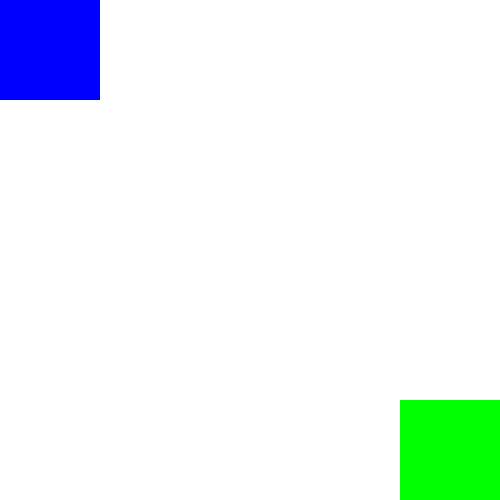

In [119]:
simulate_policy(env, policy, scale=100, agent_name="VI")
# Display GIF
gif_path = "visualisations/VI_policy.gif" 
Image(gif_path)

In [122]:
# Visualise the Value Function
def visualize_value_function(V, agent_name="PI", env_size=5):
    """
    Display the state values as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    
    # Populate the value grid with state values
    value_grid = np.array(list(V.values())).reshape(env_size, env_size)
    
    # Create the heatmap visualization
    plt.imshow(value_grid, cmap='viridis')
    plt.colorbar(label='State Value')
    plt.title('Learned State Values')
    
    # Add value text in each cell for precision
    for row in range(env_size):
        for col in range(env_size):
            value = value_grid[row, col]
            text_color = "white" if value < 0.5 * np.max(value_grid) else "black"
            plt.text(col, row, f"{value:.2f}",
                     ha="center", va="center", color=text_color)

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"visualisations/{agent_name}_value_function.png")
    plt.show()
    plt.close()
    print("Value function visualisation saved")

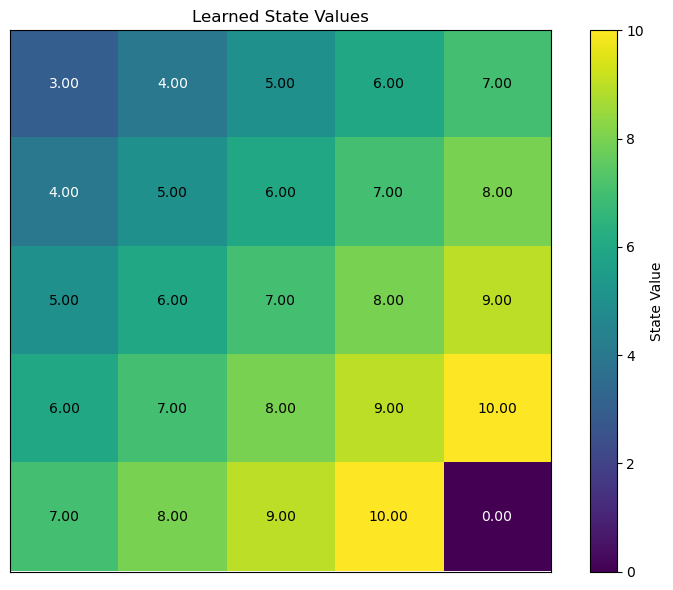

Value function visualisation saved


In [123]:
visualize_value_function(V, agent_name="VI")

### Stochastic FrozenLake

In [103]:
# Environment
env = gym.make("FrozenLake-v1", is_slippery=True, success_rate=1.0/3.0, 
               reward_schedule=(1, 0, 0), render_mode='rgb_array'
              )
env.reset()
num_states = env.observation_space.n
num_actions = env.action_space.n

In [104]:
VI = ValueIteration(env, num_states, num_actions, gamma=.8, theta=1e-3)
policy, V = VI.value_iteration()

In [105]:
policy

{0: 2,
 1: 3,
 2: 2,
 3: 1,
 4: 2,
 5: 0,
 6: 2,
 7: 0,
 8: 3,
 9: 2,
 10: 2,
 11: 0,
 12: 0,
 13: 3,
 14: 3,
 15: 0}

In [106]:
V

{0: 0.32768000000000014,
 1: 0.40960000000000013,
 2: 0.5120000000000001,
 3: 0.40960000000000013,
 4: 0.40960000000000013,
 5: 0.0,
 6: 0.6400000000000001,
 7: 0.0,
 8: 0.5120000000000001,
 9: 0.6400000000000001,
 10: 0.8,
 11: 0.0,
 12: 0.0,
 13: 0.8,
 14: 1.0,
 15: 0.0}

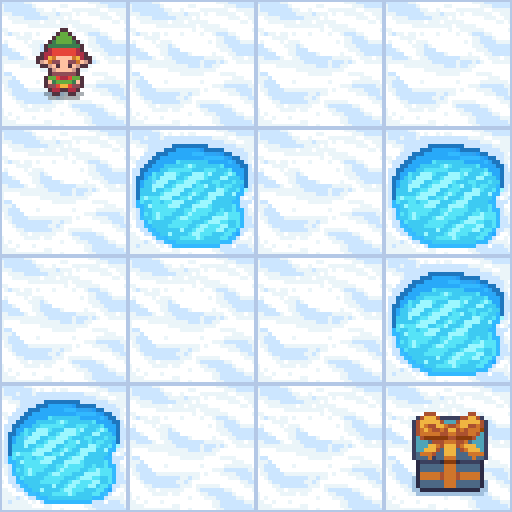

In [108]:
simulate_policy(env, policy, scale=2, agent_name="VI-FrozenLake")
# Display GIF
gif_path = "visualisations/VI-FrozenLake_policy.gif" 
Image(gif_path)

In [109]:
def visualize_frozenlake(V, policy, env, agent_name="PI"):

    env_size = env.unwrapped.nrow
    desc = env.unwrapped.desc.astype(str)

    # Construct value grid safely
    value_grid = np.array([V[s] for s in range(env_size**2)])
    value_grid = value_grid.reshape(env_size, env_size)

    plt.figure(figsize=(7, 7))
    plt.imshow(value_grid, cmap="viridis", vmin=0, vmax=1)
    plt.colorbar(label="State Value")

    # Action to arrow mapping
    action_arrows = {
        0: "←",
        1: "↓",
        2: "→",
        3: "↑"
    }

    max_val = np.max(value_grid)

    for row in range(env_size):
        for col in range(env_size):
            state = row * env_size + col
            value = value_grid[row, col]
            tile = desc[row, col]

            # Base tile label
            label = tile

            # Overlay policy arrow only for non-terminal states
            if tile not in ["H", "G"]:
                arrow = action_arrows.get(policy[state], "")
                label = f"{tile}\n{arrow}"

            # Choose text color based on brightness
            text_color = "white" if value < 0.5 * max_val else "black"

            plt.text(col, row,
                     f"{label}\n{value:.2f}",
                     ha="center", va="center",
                     color=text_color,
                     fontsize=10)

    plt.title(f"{agent_name} - FrozenLake Value Function & Policy")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.savefig(f"visualisations/{agent_name}_frozenlake_value_function.png")
    plt.show()
    plt.close()

    print("FrozenLake visualization saved.")

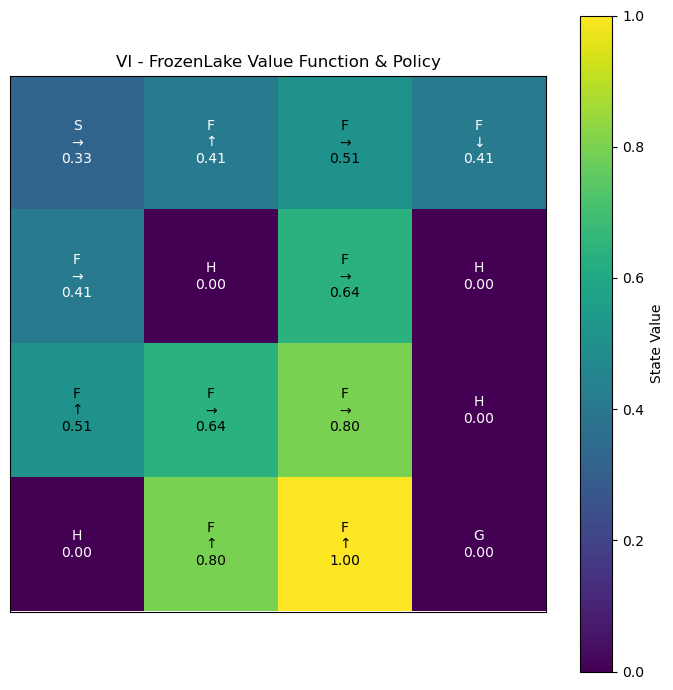

FrozenLake visualization saved.


In [110]:
visualize_frozenlake(V, policy, env, agent_name="VI")